#### Importthe libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import datetime as dt

#### Read the data

In [2]:
# use pandas to read in the csv file
bike_df = pd.read_csv('./day.csv')

#### Converting date to day
Month and Year are not required as they have been provided.

In [3]:
# we want to see if day has any impact on bike rental so we parse out the day from the date column
bike_df['day'] = bike_df['dteday'].apply(lambda x: dt.datetime.strptime(x, '%d-%m-%Y').day)
bike_df = bike_df.drop(['dteday'], axis=1)

In [4]:
# The current data type has no missing data.  All columns have 730 rows. All columns are numeric in nature.
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
 15  day         730 non-null    int64  
dtypes: float64(4), int64(12)
memory usage: 91.4 KB


In [5]:
# Pandas.DataFrame.nunique() function return Series with number of distinct observations over requested axis.
# season, yr, month, holiday, weekday, workingday and weathersit must be converted from numeric to category.
bike_df.nunique()

instant       730
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
casual        605
registered    678
cnt           695
day            31
dtype: int64

Initializing variable for TARGET and binary so they can be easily be referenceable from the codes.

#### Columns evaluation
Binary columns (with 0 & 1) are: yr, holiday, and working day

Columns that can turn into dummies variable is: weathsit

Columns that can turn into categorical are: 'season','mnth','yr','holiday','weekday','workingday','weathersit','day'

In [6]:
# Target 'cnt' is the dependent variable that we want to predict
TARGET = 'cnt'

In [7]:
# here are all the binary columns
YESNO = ['yr','holiday','workingday']

#### Change Data Categories
Convert numerical to categorical variables

In [8]:
#category_cols=['season','mnth','weathersit','day']
category_cols=['season','yr','mnth','holiday','weekday','workingday','weathersit','day']
for col in category_cols:
  bike_df[col]=bike_df[col].astype('category')

In [9]:
# Let's take a peek at the data type again after the conversion
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   instant     730 non-null    int64   
 1   season      730 non-null    category
 2   yr          730 non-null    category
 3   mnth        730 non-null    category
 4   holiday     730 non-null    category
 5   weekday     730 non-null    category
 6   workingday  730 non-null    category
 7   weathersit  730 non-null    category
 8   temp        730 non-null    float64 
 9   atemp       730 non-null    float64 
 10  hum         730 non-null    float64 
 11  windspeed   730 non-null    float64 
 12  casual      730 non-null    int64   
 13  registered  730 non-null    int64   
 14  cnt         730 non-null    int64   
 15  day         730 non-null    category
dtypes: category(8), float64(4), int64(4)
memory usage: 54.2 KB


### Exploratory Data Analysis (EDA)
#### Use boxplot to find correlations for categorical data set
There eight categorical variables.  Each one is plotted against the TARGET ('cnt') variable.

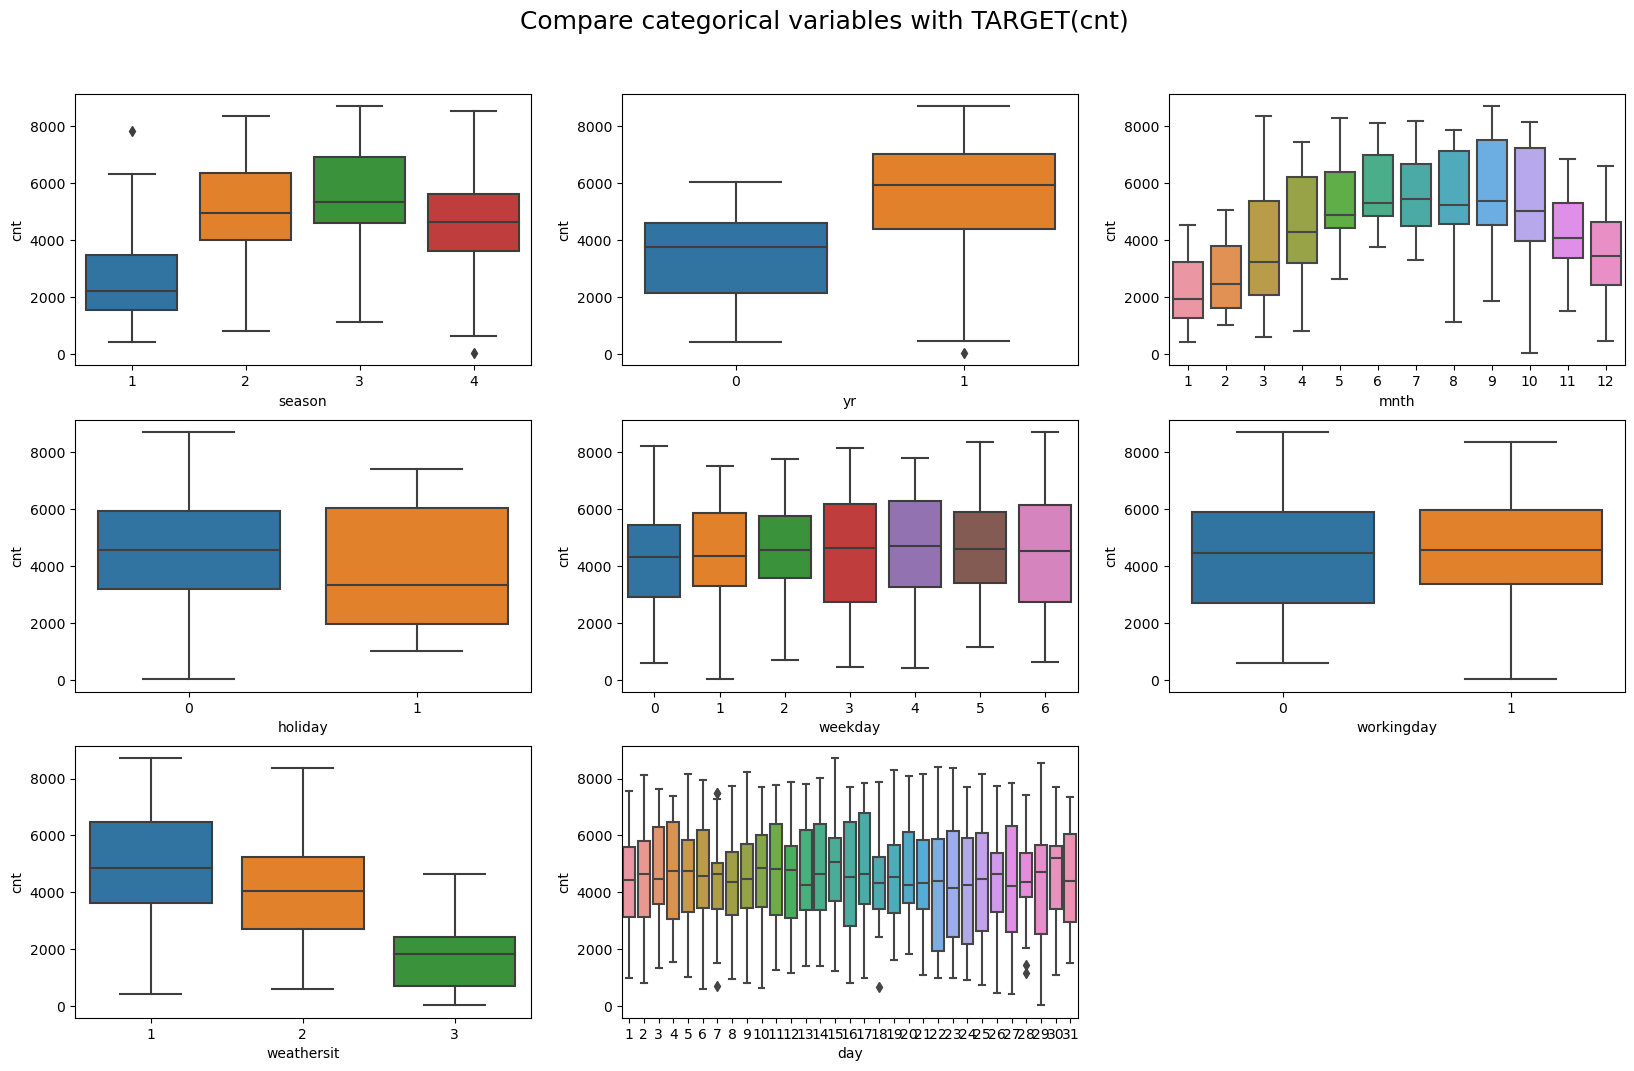

In [10]:
# set the figure sizes, spaces, and fontsize
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Compare categorical variables with TARGET(cnt)", fontsize=18, y=0.95)

# set number of columns (use 3 to demonstrate the change)
ncols = 3
# calculate number of rows
nrows = len(category_cols) // ncols + (len(category_cols) % ncols > 0)

for n, m in enumerate(bike_df[category_cols]):
    # add a new subplot iteratively using nrows and cols
    ax = plt.subplot(nrows, ncols, n + 1)

    # filter df and plot ticker on the new subplot axis
    sns.boxplot(x=bike_df[category_cols[n]], y=bike_df[TARGET], ax=ax)
    ax.set_xlabel(category_cols[n])

#### Analysis based on boxplot:
- Season: Falls has the highest bike rental counts. Spring has the lowest bike rental count.
- Month: More bike rentals occur between May and September
- Year: 2019 bike rental is higher than 2018 suggesting the trend it up.
- Holiday: non-holiday (0) has a wider range compared to holiday
- Weekday: Wednesday and Thursday appear to have more bike rental
- Workingday: inconclusive 
- Weathersit: Bike rental is high  when it is  Clear, Few clouds, Partly cloudy, Partly cloudy
- Day: It seems that bike rental occur more in the middle of the month

#### Use heatmap to find correlations for numerical data set
* highly correlated variables will be dropped as they don't add value to our training

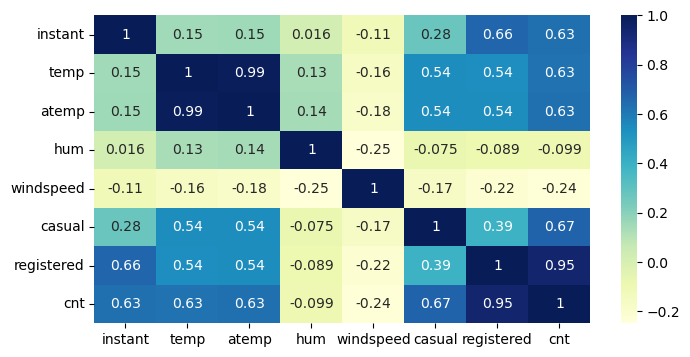

In [11]:
# set chart size, color and turn annotation on (numbers inside the chart)
plt.figure(figsize=(8,4))
sns.heatmap(bike_df.corr(), annot=True, cmap="YlGnBu")
plt.show()

Dark blue represesnt high correlation.  Temperature, Registered and Casual users are among the highest in term of correlation. Let's view it in a different way that is a bit more easier to read.

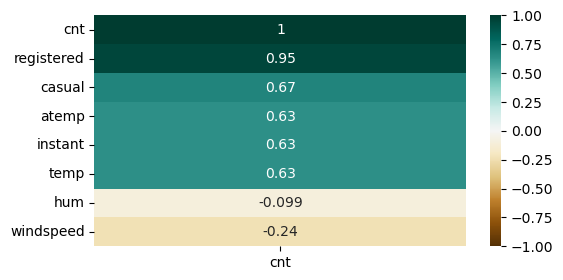

In [12]:
# Perform correlation against the TARGET ('cnt') variable
corr = bike_df.corr()
plt.figure(figsize=(6, 3))
sns.heatmap(corr[[TARGET]].sort_values(by=TARGET, ascending=False), vmin=-1, annot=True, cmap='BrBG');
corr_order = corr[[TARGET]].sort_values(by=TARGET, ascending=False).index

#### Drop unnecessary columns
* 'instant' is the numeric count.  It is not necessary for model training.
* from the correlation study above, both 'registered' and 'casual' are highly correlated to 'cnt' so they can be dropped
* we keep 'cnt' for now as it is our target variable

In [13]:
bike_df.drop(['instant','registered','casual','atemp'], axis=1, inplace=True)

Store categorical and numerical values inside variables so we can easily reference them

In [14]:
bike_categorical = bike_df.select_dtypes(include='category')
bike_numerical = bike_df.select_dtypes(include='number')

In [15]:
print("There are {} rows and {} columns in this data set.".format(bike_df.shape[0], bike_df.shape[1]))
print("There is {} categorical data and {} numerical data.".format(bike_categorical.shape[1], bike_numerical.shape[1]) )
print("There is {} missing data and {} duplicate values".format(bike_df.isnull().sum()[1].sum(), len(bike_df[bike_df.duplicated()])))
print("The Target variable is 'cnt'")

There are 730 rows and 12 columns in this data set.
There is 8 categorical data and 4 numerical data.
There is 0 missing data and 0 duplicate values
The Target variable is 'cnt'


#### Using the positive correlated variables from above to plot against cnt.

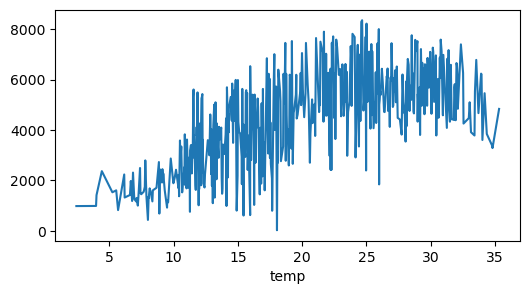

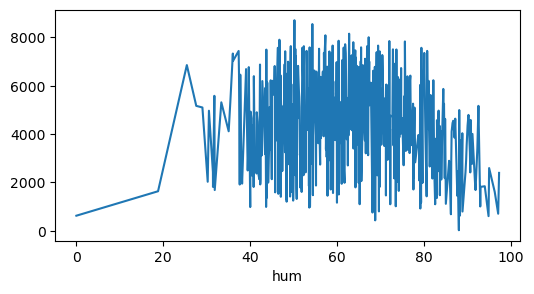

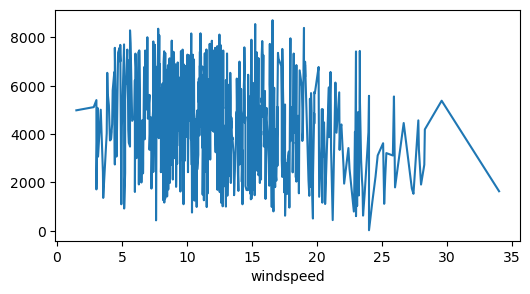

In [16]:
# plots to analyze the distribution of all numerical features
# for col in ['hum', 'windspeed','atemp','temp','day']:
for col in bike_numerical:
    if col != TARGET:
      plt.figure(figsize=(6,3))
      bike_df.groupby(col).mean()[TARGET].plot()
      plt.xlabel(col)
plt.show()


We can clearly see casual and registered are in upward incline.  

#### Map out numerical assignment to human readable text

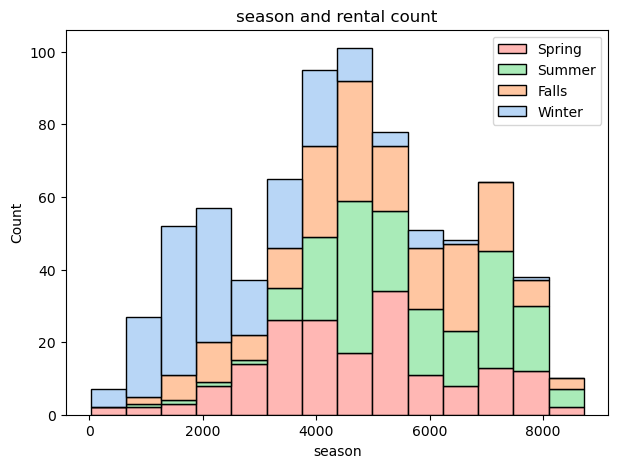

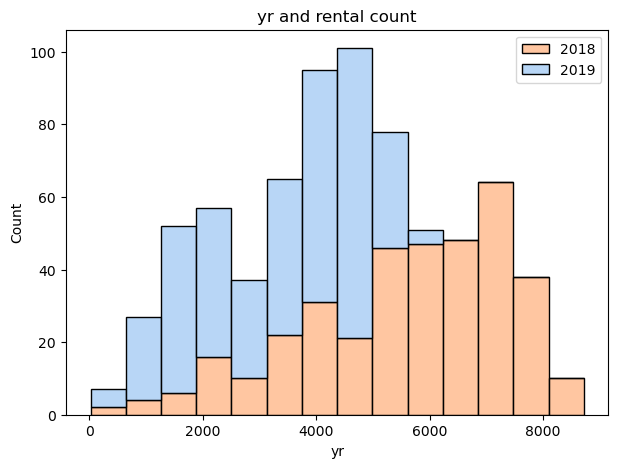

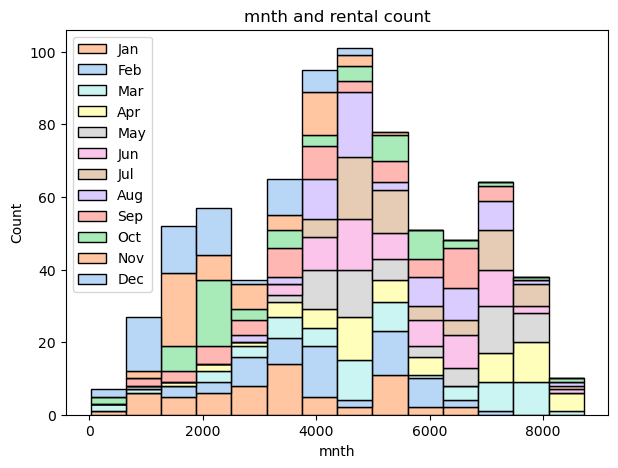

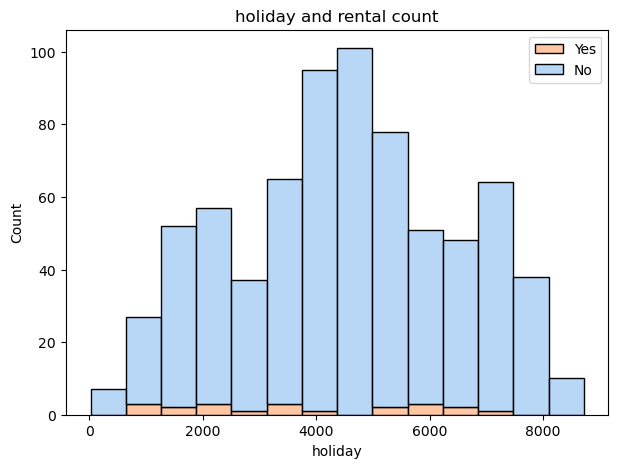

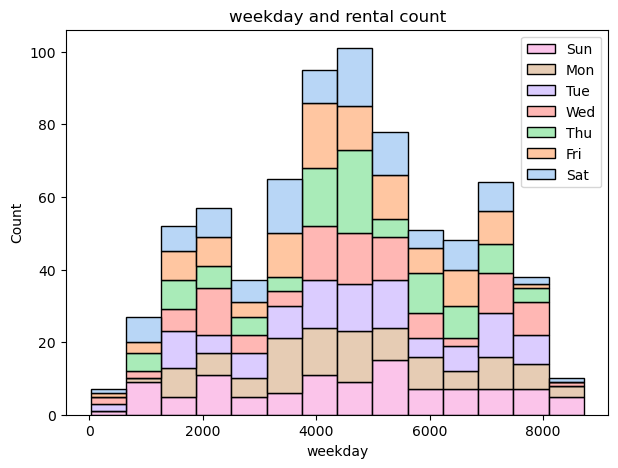

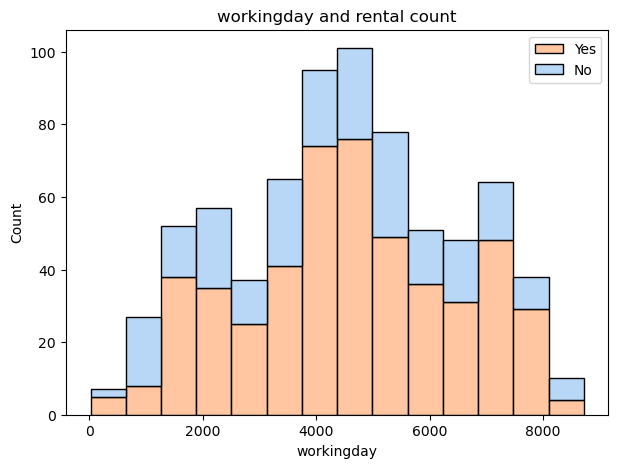

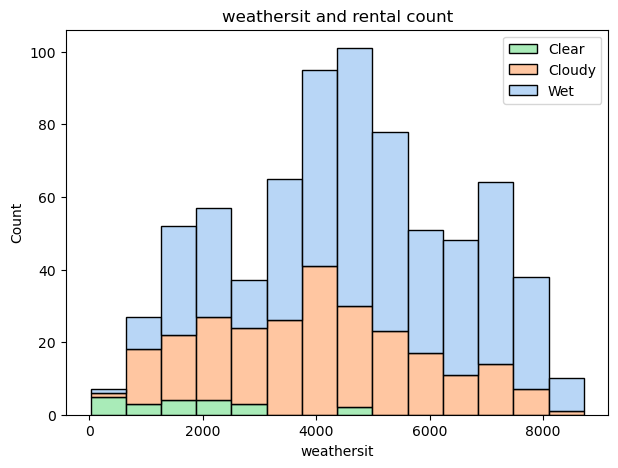

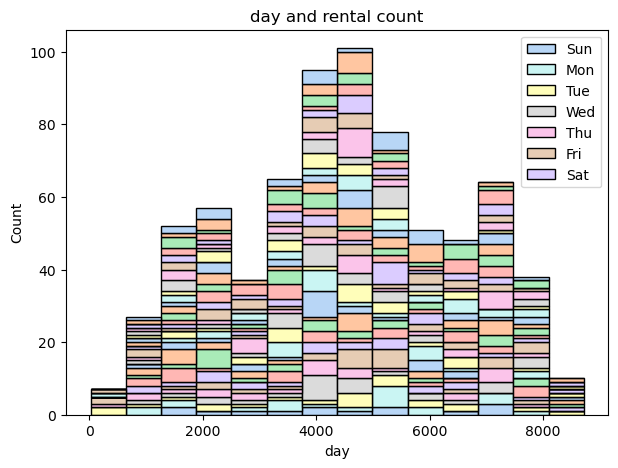

In [17]:
dictonary = {'season': ['Spring', 'Summer', 'Falls', 'Winter'],
             'yr': [2018, 2019],
             'mnth': ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
             'holiday':['Yes','No'],
             'weekday':['Sun','Mon','Tue','Wed','Thu','Fri','Sat'],
             'workingday':['Yes','No'],
             'weathersit':['Clear','Cloudy','Wet','Heavy Snow/Rain'],
             'day':['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
            }    

for k,v in dictonary.items():
    f = plt.figure(figsize=(7,5))
    ax = f.add_subplot(1,1,1)
    sns.histplot(data=bike_df, ax=ax, stat="count", multiple="stack",
                 x=TARGET,kde=False,
                 palette="pastel", hue=bike_df[k],
                 element="bars", legend=True)
    ax.set_title(f"{k}" " and rental count")
    ax.set_xlabel(k)
    ax.legend(v)
    ax.set_ylabel("Count")


#### Perform Simple Linear Regression
Quickly see which variable has positive impact on the model to be trained.

Based on the chart below, Registered is the most probable variable to be trained first.

In [18]:
# Create a one off VIF function in case we need to call it separately
def get_vif(x):
    vif = pd.DataFrame()
    vif['Features'] = x.columns
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1]) if (x.shape[1]>0)]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending=False)
    return vif

In [19]:
def train_model(x, m, vif):
    # These global variables enable us to reference them outside of the function
    global lr_model, mlr_model, rfe_model
    global X_train_lr
    global X_train_mlr
    global X_train_rfe
  
    # Depending on user input, run one of the training jobs
    if m == mlr:
        X_train_mlr = sm.add_constant(x)
        mlr_model = sm.OLS(y_train, X_train_mlr).fit()
        return mlr_model.summary(),vif
    
    elif m == rfe:
        X_train_rfe = sm.add_constant(x)
        rfe_model = sm.OLS(y_train, X_train_rfe).fit()
        get_vif(x)
        return rfe_model.summary(),vif
    
    if m == lr:
        X_train_lr = sm.add_constant(x)
        lr_model = sm.OLS(y_train, X_train_lr).fit()
        return mlr_model.summary()
    
    else:
        print("Which model do you wish to train?")


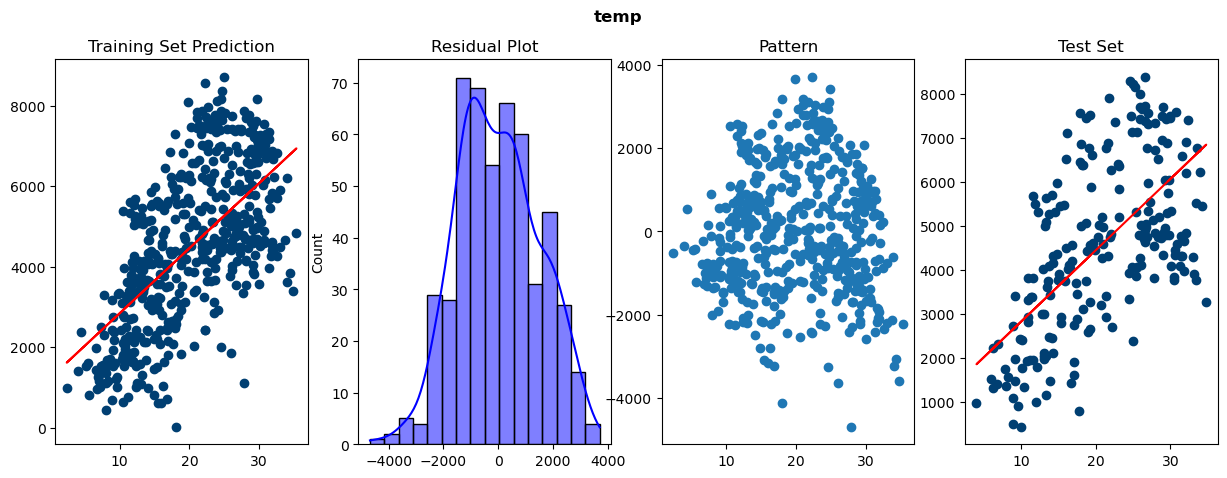

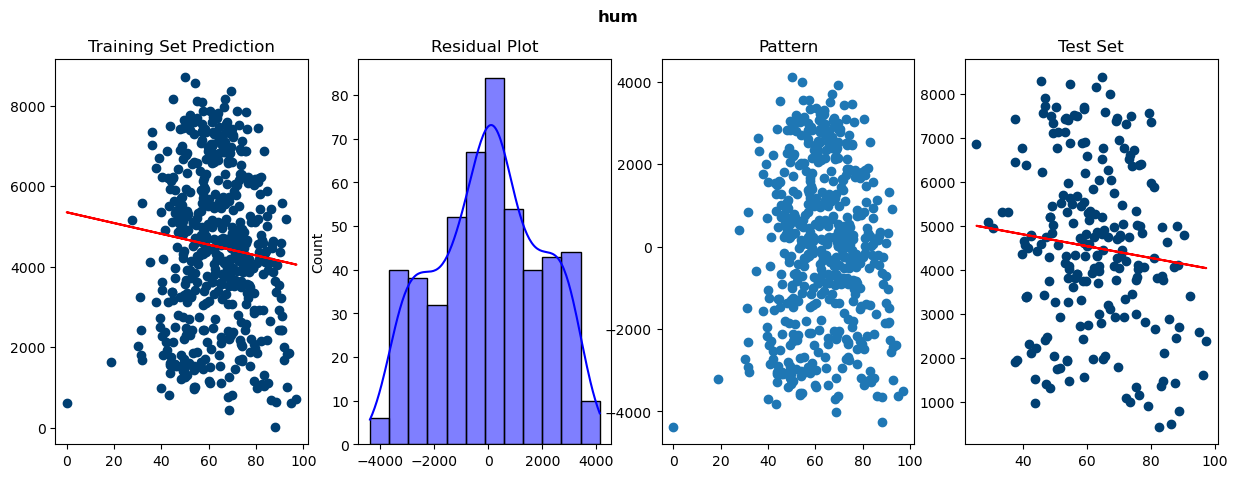

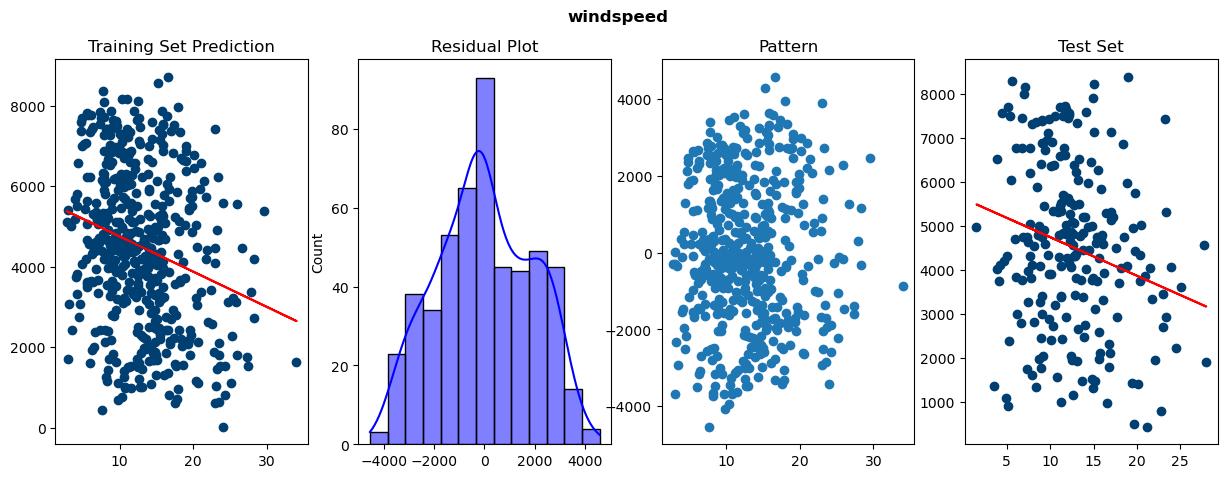

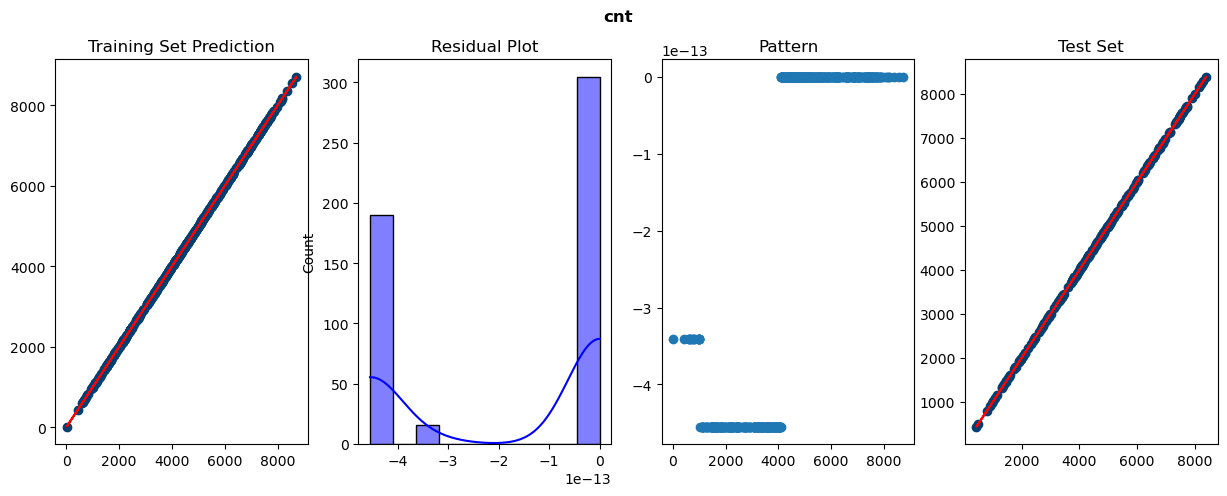

In [20]:
# making three copies of the dataframe as we'll be training multiple models
rfe_df = bike_df
mlr_df = bike_df
df2=bike_df
adv = bike_numerical
for i in adv:
    x = df2[i]
    y = df2[TARGET]
    m = (x.mean() * y.mean() - (x*y).mean())/((x.mean() * x.mean())-(x * x).mean())
    b = y.mean() - m*x.mean()
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.70, random_state=100)
    
    # train the model
    X_train_sm = sm.add_constant(X_train)
    lr =sm.OLS(y_train, X_train_sm)
    lr_model = lr.fit()

    # make prediction
    y_train_pred = lr_model.predict(X_train_sm)
    res = y_train - y_train_pred

    # plot the prediction in red  
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,5))
    fig.suptitle(i, fontweight ="bold")

    # plot training set
    ax1.scatter(X_train, y_train, color='#003F72')
    ax1.plot(X_train, b + m * X_train, 'r' )
    ax1.set_title("Training Set Prediction")
    
    # plot distribution for residual analysis
    sns.histplot(res, color='blue', kde=True, ax=ax2)
    ax2.set_title("Residual Plot")
    
    ax3.scatter(X_train, res)
    ax3.set_title("Pattern")
    
    # plot test set
    ax4.scatter(X_test, y_test, color='#003F72')
    ax4.plot(X_test, b + m * X_test, 'r' )
    ax4.set_title("Test Set")
    
    plt.show()

#### Multiple Linear Regression

##### Create dummy variables
Drop the original categorical data after concatenation.

In [21]:
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,day
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,985,1
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,801,2
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349,3
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562,4
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600,5


In [22]:
bike_categorical.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'day'],
      dtype='object')

In [23]:
#DUMMIES = ['weathersit']
DUMMIES = [x for x in bike_categorical.columns if x not in YESNO ]
DUMMY_COLS = pd.get_dummies(bike_df[DUMMIES], drop_first=True)
bike_df = pd.concat([bike_df, DUMMY_COLS], axis=1)
bike_df = bike_df.drop(DUMMIES, axis=1)
bike_df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_2,season_3,season_4,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,0,0,0,14.110847,80.5833,10.749882,985,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,14.902598,69.6087,16.652113,801,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Some variables must be scaled for efficient training: temp, atemp, hum, windspeed, casual, registered, cnt

#### Train Test Split
We're using one of the clone dataframe (mlr_df). Split it into 70% train and 30% test.

In [24]:
mlr_train, mlr_test = train_test_split(mlr_df, train_size=0.7, random_state=100)
print(mlr_train.shape)
print(mlr_test.shape)

(510, 12)
(220, 12)


#### Scaling the data
Apply scaler() to all the columns except the 'YESNO' and 'DUMMIES' variables

Pre-processing the data is one of the most important steps during the creation of a machine learning model. This includes normalization, feature scaling, and feature extraction.

There are ways to improve the performance of your machine learning models and avoid the bad side effects of scaling.

The most common techniques used to scale features are standardization, normalization, and feature extraction.

In [25]:
EXCLUDE = pd.concat([bike_df[YESNO], bike_df[DUMMY_COLS.columns]], axis=1).columns

In [26]:
SCALED = bike_df.loc[:,~bike_df.columns.isin(EXCLUDE)]

In [27]:
SCALED

,temp,hum,windspeed,cnt
0,14.110847,80.5833,10.749882,985
1,14.902598,69.6087,16.652113,801
2,8.050924,43.7273,16.636703,1349
3,8.200000,59.0435,10.739832,1562
4,9.305237,43.6957,12.522300,1600
...,...,...,...,...
725,10.420847,65.2917,23.458911,2114
726,10.386653,59.0000,10.416557,3095
727,10.386653,75.2917,8.333661,1341
728,10.489153,48.3333,23.500518,1796


In [28]:
# Scale the numerical data between 0 and 1
scaler = MinMaxScaler()

# Fit on data
mlr_train[SCALED.columns] = scaler.fit_transform(mlr_train[SCALED.columns])

In [29]:
mlr_train.describe()

,temp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.650480,0.320883,0.513499
std,0.225858,0.145846,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.538643,0.199179,0.356420
50%,0.542596,0.653714,0.296763,0.518638
75%,0.735215,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000


In [30]:
# Let's drop the TARGET variable and train the model
# X_train, y_train
y_train = mlr_train.pop(TARGET)
X_train = mlr_train

#### Createa functions so it can be re-used as we will manually add one variable at a time
This function takes two parameter input. x is the training set and m is the type of model we're training (i.e simple linear regression, multiple linear regression or Recursive Feature Elimination (RFE))

Variance Inflation Factors (VIF) measure how much the variance of the estimated regression coefficients are inflated as compared to when the predictor variables are not linearly related.

### For the first model, we add one variable at a time in according with our correlation study above.

Lets ignore the TARGET variable and start training the model with next highest correlated variables.  Then, start add more variables.

In [31]:
# initialize the variable for our function above
lr, mlr, rfe = 0, 0, 0

In [32]:
# build a model with one variables. Corr study shows that 'tmp' is the next highest corr after we dropped 'atemp'
X_train_sm = sm.add_constant(X_train['temp'])
train_model(X_train_sm, mlr,get_vif(X_train_sm))

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.416
 Model:                            OLS   Adj. R-squared:                  0.415
 Method:                 Least Squares   F-statistic:                     362.0
 Date:                Wed, 14 Dec 2022   Prob (F-statistic):           2.46e-61
 Time:                        06:29:06   Log-Likelihood:                 176.09
 No. Observations:                 510   AIC:                            -348.2
 Df Residuals:                     508   BIC:                            -339.7
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

R-squared is 41/6% with just one variable added.  P-Value is zero.

After adding 'temp', we only get 41.5% for R-squared.  Let's add 'temp','hum','windspeed' altogether and retrain the model.

In [33]:
X_train_sm = sm.add_constant(X_train[['temp','mnth','weekday']])
train_model(X_train_sm, mlr,get_vif(X_train_sm))

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.435
 Model:                            OLS   Adj. R-squared:                  0.431
 Method:                 Least Squares   F-statistic:                     129.7
 Date:                Wed, 14 Dec 2022   Prob (F-statistic):           2.43e-62
 Time:                        06:29:06   Log-Likelihood:                 184.39
 No. Observations:                 510   AIC:                            -360.8
 Df Residuals:                     506   BIC:                            -343.8
 Df Model:                           3                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

After adding three  'temp','hum','windspeed', there wasn't much improvement on R-squared.  Let's add all the variables and then work backward by droppinig one variable at a time. 
#### Lets add all the variables
Then, we'll try to remove one variable at a time.

In [34]:
X_train_lm = sm.add_constant(X_train)
train_model(X_train_lm, mlr,get_vif(X_train_lm))

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.803
 Model:                            OLS   Adj. R-squared:                  0.798
 Method:                 Least Squares   F-statistic:                     184.3
 Date:                Wed, 14 Dec 2022   Prob (F-statistic):          1.23e-167
 Time:                        06:29:06   Log-Likelihood:                 452.90
 No. Observations:                 510   AIC:                            -881.8
 Df Residuals:                     498   BIC:                            -831.0
 Df Model:                          11                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

After we added all variables,  the R-squared is 81.1%.  The p-values for 'mnt' and 'day' are high. but the VIF are low.  Let's remove one variable at a time starting with the highest value of both VIF and p-value.

Between the VIF and p-value, 'instant' should be dropped first as it has the highest values.

In [35]:
# drop and train
X = X_train.drop('mnth', axis=1)
# train_model(X, mlr)
train_model(X, mlr,get_vif(X))

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.803
 Model:                            OLS   Adj. R-squared:                  0.799
 Method:                 Least Squares   F-statistic:                     203.0
 Date:                Wed, 14 Dec 2022   Prob (F-statistic):          1.01e-168
 Time:                        06:29:06   Log-Likelihood:                 452.72
 No. Observations:                 510   AIC:                            -883.4
 Df Residuals:                     499   BIC:                            -836.9
 Df Model:                          10                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

After dropping 'mnth' R-square remained at 81.1%.  However, the p-value for 'day' is high so let's drop it.

In [36]:
X = X.drop('day', axis=1)
train_model(X, mlr,get_vif(X))

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.802
 Model:                            OLS   Adj. R-squared:                  0.799
 Method:                 Least Squares   F-statistic:                     225.6
 Date:                Wed, 14 Dec 2022   Prob (F-statistic):          8.77e-170
 Time:                        06:29:06   Log-Likelihood:                 452.41
 No. Observations:                 510   AIC:                            -884.8
 Df Residuals:                     500   BIC:                            -842.5
 Df Model:                           9                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

In [37]:
# humidy (hum) is the next highest on the list so we'll drop it next
X = X.drop('workingday', axis=1)
train_model(X, mlr,get_vif(X))

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.801
 Model:                            OLS   Adj. R-squared:                  0.798
 Method:                 Least Squares   F-statistic:                     251.9
 Date:                Wed, 14 Dec 2022   Prob (F-statistic):          3.69e-170
 Time:                        06:29:06   Log-Likelihood:                 450.44
 No. Observations:                 510   AIC:                            -882.9
 Df Residuals:                     501   BIC:                            -844.8
 Df Model:                           8                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

X4 = X3.drop('temp', axis=1)
X_train_lm = sm.add_constant(X4)
lr_2 = sm.OLS(y_train, X_train_lm).fit()
lr_2.summary()

In [38]:
#change from workingday to holiday
X = X.drop('hum', axis=1)
train_model(X, mlr,get_vif(X))

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.799
 Model:                            OLS   Adj. R-squared:                  0.796
 Method:                 Least Squares   F-statistic:                     284.7
 Date:                Wed, 14 Dec 2022   Prob (F-statistic):          2.90e-170
 Time:                        06:29:06   Log-Likelihood:                 447.76
 No. Observations:                 510   AIC:                            -879.5
 Df Residuals:                     502   BIC:                            -845.6
 Df Model:                           7                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

Now,the R-squared is 79.9%, and the p-values have dropped to below 0.005. For this case study, it is sufficed.

#### Perform Residual Analysis
Residuals is the difference between actual values and predicted values

In [39]:
y_train_predict = mlr_model.predict(X_train_mlr)

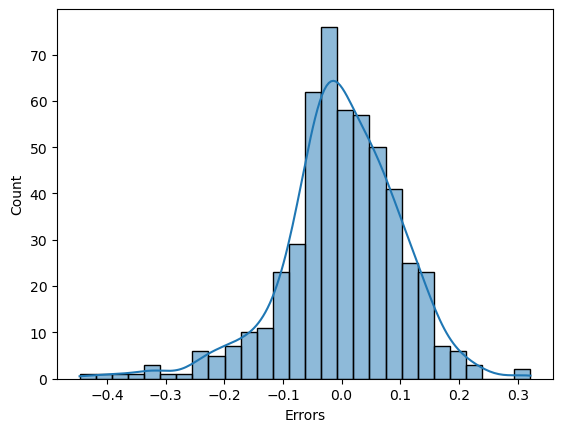

In [40]:
res = y_train - y_train_predict
sns.histplot(res, kde=True)
plt.xlabel('Errors');

The error distribution curve is normal.

#### Making Prediction
For training data, we do fit_transform.  On the other hand, for test data, we only do transform.

In [41]:
mlr_test[SCALED.columns] = scaler.transform(mlr_test[SCALED.columns])

Once again, we drop the target variable before we do anything else.

In [42]:
y_test = mlr_test.pop(TARGET)
X_test = mlr_test

#### Dividing into X_test and y_test
In this section, we'll test to see how our model performed.

In [43]:
# Adding constant variable to test dataframe
X_test_model = sm.add_constant(X_test)

In [44]:
X_test_model = X_test_model.drop(['mnth','hum','workingday','day'], axis=1)

In [45]:
# Making predictions using the final model

y_test_pred = mlr_model.predict(X_test_model)

#### Model Evaluation

Text(0, 0.5, 'y_pred')

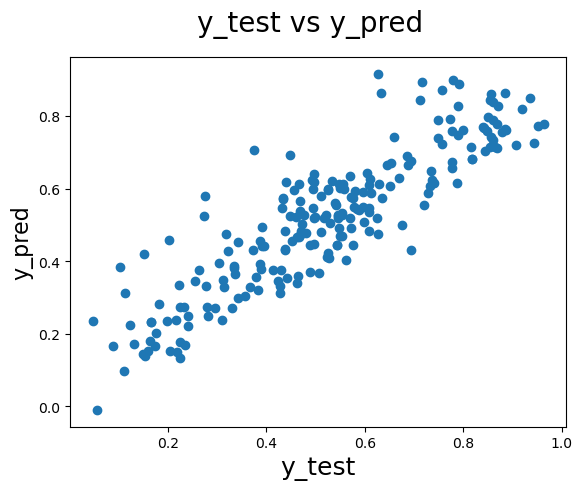

In [46]:
# Plotting y_test and y_pred_model to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

This is showing us the data is linearly trending upward.

In [47]:
# evaluate the model
r2_score(y_true=y_test, y_pred=y_test_pred)

0.7799812920685201

R2 has no such thing as “the square of something.” It could be positive, negative or zero, depending on

r2 should be between 0 and 1.  The closer to 1 the better the model.

### For the second model, we use Recursive Feature Elimination (RFE)

In [48]:
# The dummy variable is still the same. This time, we'll use an clone of the dataframe, rfe_df.
DUMMIES = [x for x in bike_categorical.columns if x not in YESNO ]
DUMMY_COLS = pd.get_dummies(rfe_df[DUMMIES], drop_first=True)
rfe_df = pd.concat([rfe_df, DUMMY_COLS], axis=1)
rfe_df = rfe_df.drop(DUMMIES, axis=1)
rfe_df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_2,season_3,season_4,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,0,0,0,14.110847,80.5833,10.749882,985,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,14.902598,69.6087,16.652113,801,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Train Test Split

In [49]:
# We'll do a train, test split like before
rfe_train, rfe_test = train_test_split(rfe_df, train_size=0.7, random_state=100)
print(rfe_train.shape)
print(rfe_test.shape)

(510, 59)
(220, 59)


#### Scaling the data
Apply scaler() to all the columns except the 'YESNO' and 'DUMMIES' variables


In [50]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [51]:
EXCLUDE = pd.concat([rfe_df[YESNO], rfe_df[DUMMY_COLS.columns]], axis=1).columns
SCALED = rfe_df.loc[:,~rfe_df.columns.isin(EXCLUDE)]

In [52]:
#1 Scale the numerical data
scaler = MinMaxScaler()

#2. Fit on data
rfe_train[SCALED.columns] = scaler.fit_transform(rfe_train[SCALED.columns])

In [53]:
# Now all variables are normalized between 0 and 1
rfe_train.describe()

,temp,hum,windspeed,cnt,season_2,season_3,season_4,mnth_2,mnth_3,mnth_4,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.650480,0.320883,0.513499,0.247059,0.262745,0.247059,0.066667,0.098039,0.078431,...,0.039216,0.025490,0.037255,0.027451,0.031373,0.029412,0.031373,0.035294,0.029412,0.017647
std,0.225858,0.145846,0.169803,0.224421,0.431725,0.440557,0.431725,0.249689,0.297660,0.269113,...,0.194298,0.157763,0.189572,0.163554,0.174494,0.169124,0.174494,0.184703,0.169124,0.131794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.542596,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.735215,0.754830,0.414447,0.684710,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
# Let's drop the TARGET variable and train our model
# X_train, y_train
y_train = rfe_train.pop(TARGET)
X_train = rfe_train

In [55]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

In [56]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 16),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_2', True, 1),
 ('season_3', False, 13),
 ('season_4', True, 1),
 ('mnth_2', False, 21),
 ('mnth_3', False, 9),
 ('mnth_4', False, 11),
 ('mnth_5', False, 10),
 ('mnth_6', False, 12),
 ('mnth_7', False, 42),
 ('mnth_8', False, 2),
 ('mnth_9', True, 1),
 ('mnth_10', False, 14),
 ('mnth_11', False, 43),
 ('mnth_12', False, 44),
 ('weekday_1', False, 28),
 ('weekday_2', False, 29),
 ('weekday_3', False, 31),
 ('weekday_4', False, 32),
 ('weekday_5', False, 30),
 ('weekday_6', False, 15),
 ('weathersit_2', False, 3),
 ('weathersit_3', True, 1),
 ('day_2', False, 23),
 ('day_3', False, 24),
 ('day_4', False, 35),
 ('day_5', False, 34),
 ('day_6', False, 25),
 ('day_7', False, 49),
 ('day_8', False, 41),
 ('day_9', False, 38),
 ('day_10', False, 19),
 ('day_11', False, 8),
 ('day_12', False, 20),
 ('day_13', False, 33),
 ('day_14', False, 26),
 ('day_1

RFE automatically select variables for us.  They are identified as True and 1.  Also, refer to rfe.support_ below for the list.

In [57]:
# Here are the 10 features that we asked RFE to select for us
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_2', 'season_4',
       'mnth_9', 'weathersit_3', 'day_31'],
      dtype='object')

In [58]:
X_train.columns[~rfe.support_]

Index(['workingday', 'season_3', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_10', 'mnth_11', 'mnth_12',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weathersit_2', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12',
       'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19',
       'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26',
       'day_27', 'day_28', 'day_29', 'day_30'],
      dtype='object')

Let's train our RFE model using the suggested rfe.support_ columns.

In [59]:
# We're going to manual train the model using the RFE automatic feature selection.  Then, we'll use our prebuilt function above.

X_train_rfe = X_train[col]
X_train_rfe = sm.add_constant(X_train_rfe)
rfe_model = sm.OLS(y_train, X_train_rfe).fit()
X_train_new = X_train_rfe
rfe_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     247.5
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          3.00e-186
Time:                        06:29:07   Log-Likelihood:                 494.11
No. Observations:                 510   AIC:                            -966.2
Df Residuals:                     499   BIC:                            -919.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2666      0.026     10.228      0.000       0.215       0.318
yr               0.2270      0.008     27.273      0.000       0.211       0.243
holiday         -0.0904      0.026     -3.441      0.001      -0.142      -0.039
temp             0.5944      0.020     29.701      0.000       0.555       0.634
hum             -0.2814      0.032     -8.914      0.000      -0.343      -0.219
windspeed       -0.2010      0.026     -7.703      0.000      -0.252      -0.150
season_2         0.0896      0.010      8.613      0.000       0.069       0.110
season_4         0.1444      0.011     13.571      0.000       0.123       0.165
mnth_9           0.1071      0.016      6.704      0.000       0.076       0.138
weathersit_3    -0.1986      0.026     -7.750      0.000      -0.249      -0.148
day_31           0.0809      0.031      2.577      0.010       0.019       0.143
==============================================================================
Omnibus:                       60.717   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.398
Skew:                          -0.721   Prob(JB):                     1.07e-24
Kurtosis:                       4.766   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Right of the bat, R-squared is 81.1%.  However, the p-values for 'workingday' is a bit high.  We need to drop it and retrain the model.  Rinse and repeat until p-values are significantly below 0.005 or so. 

#### Drop a variable based on highest VIF and high p-value and train the model.
Repeat the process until p-values are below 0.005

In [60]:
# mnth is the highest so we drop it first
X_train_new = X_train_new.drop(['day_31'],axis=1)
train_model(X_train_new, rfe,get_vif(X_train_new))

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.830
 Model:                            OLS   Adj. R-squared:                  0.827
 Method:                 Least Squares   F-statistic:                     271.2
 Date:                Wed, 14 Dec 2022   Prob (F-statistic):          4.74e-186
 Time:                        06:29:07   Log-Likelihood:                 490.74
 No. Observations:                 510   AIC:                            -961.5
 Df Residuals:                     500   BIC:                            -919.1
 Df Model:                           9                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

In [61]:
X_train_new = X_train_new.drop(['const'],axis=1)
train_model(X_train_new,rfe,get_vif(X_train_new))

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.830
 Model:                            OLS   Adj. R-squared:                  0.827
 Method:                 Least Squares   F-statistic:                     271.2
 Date:                Wed, 14 Dec 2022   Prob (F-statistic):          4.74e-186
 Time:                        06:29:07   Log-Likelihood:                 490.74
 No. Observations:                 510   AIC:                            -961.5
 Df Residuals:                     500   BIC:                            -919.1
 Df Model:                           9                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

#### Residual Analysis of the trained data

In [62]:
y_train_pred = rfe_model.predict(X_train_rfe)

Text(0.5, 0, 'Errors')

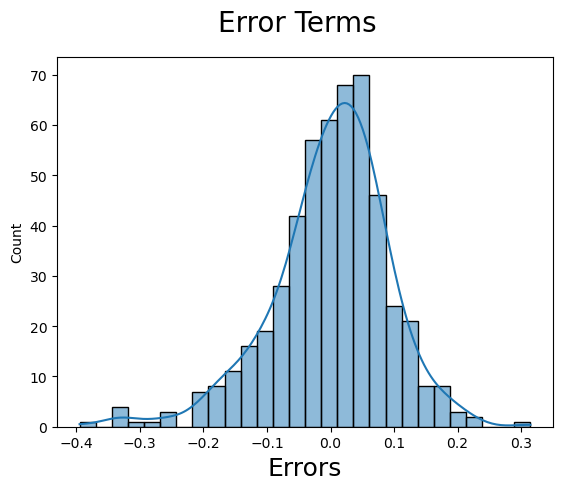

In [63]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.histplot(y_train - y_train_pred, kde=True)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

#### Making Predictions
Applying scaling on the test data

In [64]:
rfe_test[SCALED.columns] = scaler.transform(rfe_test[SCALED.columns])

In [65]:
y_test = rfe_test.pop(TARGET)
X_test = rfe_test

In [66]:
X_test_new = X_test[X_train_new.columns]
X_test_new = sm.add_constant(X_test_new)

In [67]:
print("X_test_new.shape: {}".format(X_test_new.shape))
print("X_train_new: {}".format(X_train_new.shape))

X_test_new.shape: (220, 10)
X_train_new: (510, 9)


In [68]:
# Making predictions
y_pred = rfe_model.predict(X_test_new)

Text(0, 0.5, 'y_pred')

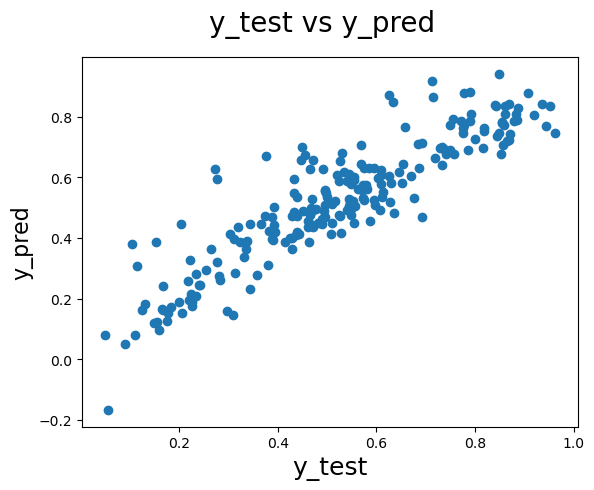

In [69]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [70]:
# evaluate the model
r2_score(y_true=y_test, y_pred=y_pred)

0.8036002511614431

r2_score is 80.3%. It is slightly better than the 77.9% that we got from manual training.  The best part is that it was faster with minimal works required.